# Taller 7 Red Neuronal MLP

<a href="https://colab.research.google.com/github/JCardenas05/Teoria_Se-ales/blob/main/Taller_5/Taller_7_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab This NoteBook"/></a>

- Jony Cardenas Herrera
- Brayan Avendaño Mesa

## Actividades
1. Crear una red neuronal multicapa (MLP)
    - Modelo implementado: red de clasificación binaria
    - Generación de datos
    - Normalización
    - Entrenamiento
    - Validación 
    
2. Evaluar el rendimiento para distintas representaciones de datos
    - $p(0) = p(1)$
    - $p(0) >> p(1)$
    - $N_1(x_1, \sigma_1) \neq N_2(x_2, \sigma_2) $
3. Agregar metricas de rendimiento
    - Matrix de confusión
    - Accuracy
    - Loss

In [375]:
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [376]:
def map_range(value, min_=0, max_=1):
        return ((value-np.min(value))/(np.max(value)-np.min(value))) * (max_ - min_)

def clearConsole():
        command = 'clear'  # Comando por defecto para sistemas Unix/Linux
        os.system(command)  # Ejecuta el comando para limpiar la consola

def predict_simbol(message_corrupt, modelo, Nsamples=500, simbols=(0,1)):
        message_predict = modelo.predict(message_corrupt).flatten()
        message_predict = np.where(message_predict >= 0.5, simbols[1], simbols[0])
        message_predict = np.repeat(message_predict, Nsamples)
        return message_predict

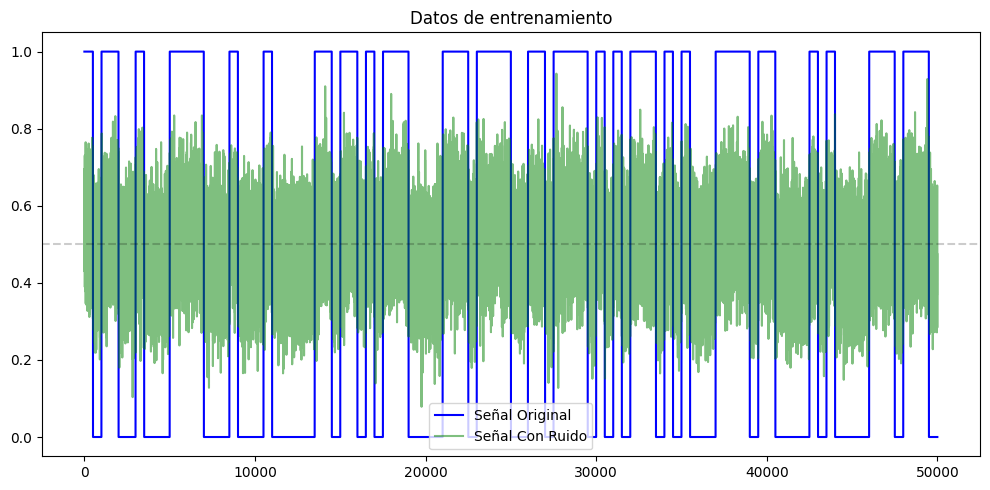

In [377]:
a1 = 1       # Valor del símbolo a1
a0 = 0    # Valor del símbolo a0

# Probabilidades de los símbolos
p_0 = 0.5
p_1 = 1 - p_0

Nsamples = 500
Nsymbols = 6000 # Número total de símbolos
N = Nsymbols * Nsamples  # Número total de muestras

o1 = 1
noise = np.random.normal(0, o1, N)
time = np.linspace(0, Nsamples*100, Nsamples*100)

data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
message_org = np.concatenate([[v]*Nsamples for v in data_test])
message_corrupt = message_org + noise

#message_test_orig = map_range(message_test_orig)
message_corrupt = map_range(message_corrupt)

message_org = np.array(np.split(message_org, Nsymbols))
message_corrupt = np.array(np.split(message_corrupt, Nsymbols))

plt.figure(figsize=(10,5),tight_layout=True) 
plt.title("Datos de entrenamiento")
plt.plot(time,message_org[:100].flatten(), color='blue', alpha=(1), label='Señal Original')
plt.plot(time,message_corrupt[:100].flatten(),color='green', alpha=0.5, label=f'Señal Con Ruido' )
plt.axhline((a0+a1)/2, color=(0,0,0,0.2), linestyle='--')  
plt.legend()
plt.show()

In [378]:
X_train, X_val, y_train, y_val = train_test_split(message_corrupt, message_org, test_size=0.2, random_state=42)
print(f'Señal Corrupta entrenamiento: {X_train.shape}')
print(f'Señal Original entrenamiento: {y_train.shape}')
print(f'Señal Corrupta validación: {X_val.shape}')
print(f'Señal Original validación: {y_val.shape}')

Señal Corrupta entrenamiento: (4800, 500)
Señal Original entrenamiento: (4800, 500)
Señal Corrupta validación: (1200, 500)
Señal Original validación: (1200, 500)


Epoch 1/70
150/150 [==============================] - 2s 5ms/step - loss: 0.2498 - accuracy: 0.4983 - val_loss: 0.2468 - val_accuracy: 0.4900
Epoch 2/70
150/150 [==============================] - 1s 4ms/step - loss: 0.2470 - accuracy: 0.5208 - val_loss: 0.2454 - val_accuracy: 0.4908
Epoch 3/70
150/150 [==============================] - 1s 4ms/step - loss: 0.2454 - accuracy: 0.5298 - val_loss: 0.2435 - val_accuracy: 0.5050
Epoch 4/70
150/150 [==============================] - 1s 4ms/step - loss: 0.2429 - accuracy: 0.5496 - val_loss: 0.2426 - val_accuracy: 0.6567
Epoch 5/70
150/150 [==============================] - 1s 4ms/step - loss: 0.2412 - accuracy: 0.5754 - val_loss: 0.2386 - val_accuracy: 0.4917
Epoch 6/70
150/150 [==============================] - 1s 4ms/step - loss: 0.2362 - accuracy: 0.5883 - val_loss: 0.2338 - val_accuracy: 0.5083
Epoch 7/70
150/150 [==============================] - 1s 4ms/step - loss: 0.2330 - accuracy: 0.6100 - val_loss: 0.2278 - val_accuracy: 0.8183
Epoch 

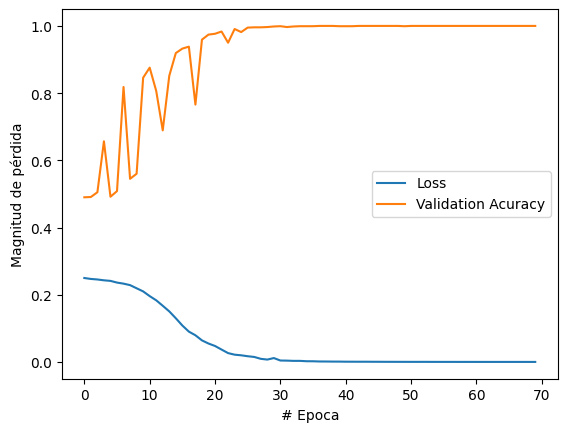

In [381]:

entrada = tf.keras.layers.Dense(units=200, input_shape=(Nsamples,))
capa1   = tf.keras.layers.Dense(units=100, activation='relu')
capa2   = tf.keras.layers.Dense(units=50, activation='relu')
capa3   = tf.keras.layers.Dense(units=25, activation='relu')
salida  = tf.keras.layers.Dense(units=1, activation='sigmoid')
modelo  = tf.keras.Sequential([entrada, capa1, capa2,capa3, salida])

# Compilación del modelo
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
               loss=tf.keras.losses.mean_squared_error,
               metrics=['accuracy']
              )

historial = modelo.fit(X_train, y_train, epochs=70, validation_data=(X_val, y_val))

clearConsole()

plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"], label='Loss')
plt.plot(historial.history["val_accuracy"], label = 'Validation Acuracy' )
plt.legend()
plt.show()

In [ ]:
def generate_symbols(a0=0, a1=1, p_0=0.5, Nsamples=500, Nsymbols=100, var_noise=0.5):
    N=Nsamples*Nsymbols
    p_1 = 1- p_0

    if type(var_noise) == tuple:
        noise_test_a0 = np.random.normal(0, var_noise[0], N)
        noise_test_a1 = np.random.normal(0, var_noise[1], N)
        noise = [noise_test_a0,noise_test_a1]
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_orig = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = []

        for i in message_test_orig:

            if i == a0:
                noise_simbol = noise_test_a0[0]
                noise_test_a0 = np.delete(noise_test_a0, 0)
            else:
                noise_simbol = noise_test_a1[0]
                noise_test_a1 = np.delete(noise_test_a1, 0)

            message_test_corrupt.append(i + noise_simbol)
    else:
        noise_test = np.random.normal(0, var_noise, N)
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_orig = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = message_test_orig + noise_test
        
    message_test_corrupt = map_range(message_test_corrupt)
    message_test_corrupt = np.array(np.split(message_test_corrupt, Nsymbols))

    time = np.linspace(0,N,N)

    return message_test_corrupt, message_test_orig, time    


## 1) Generar simboloas con la misma probabiliadd $P(0) = P(1)$

2/2 [==============================] - 0s 4ms/step


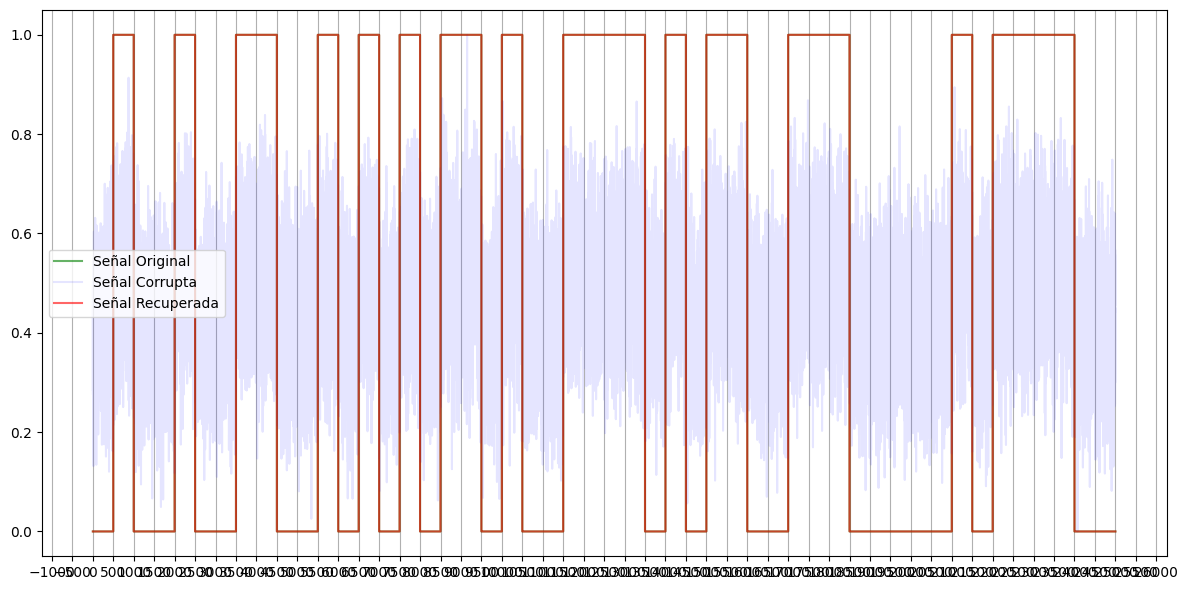

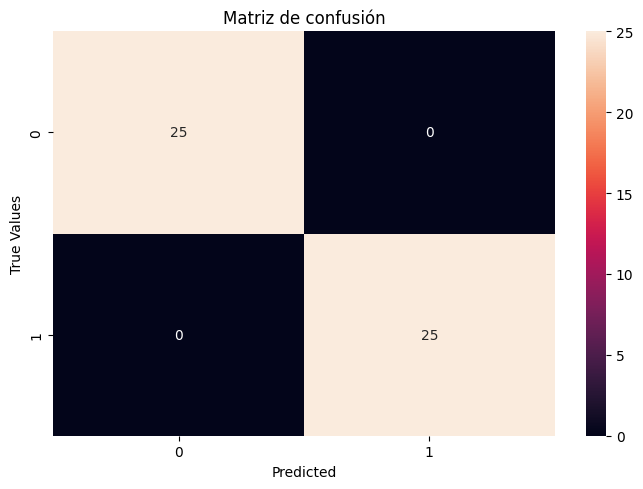

In [ ]:
Nsamples = 500
message_test_corrupt, message_test_orig, time = generate_symbols(Nsymbols=50, Nsamples=Nsamples, var_noise=1) 
message_predict = predict_simbol(message_test_corrupt, modelo, 500)

plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time,message_test_orig, 'g', label='Señal Original', alpha=0.6)
plt.step(time,message_test_corrupt.flatten(), 'b', label='Señal Corrupta', alpha=0.1)
plt.step(time,message_predict, 'r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  # Solo cuadrícula vertical
plt.show()

matrix = confusion_matrix(message_test_orig, message_predict)/Nsamples
plt.figure(figsize=(7,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()

## 2) Generar una secuencia de simbolos $0$ y $1$ con $P(0) >> p(1)$

4/4 [==============================] - 0s 4ms/step


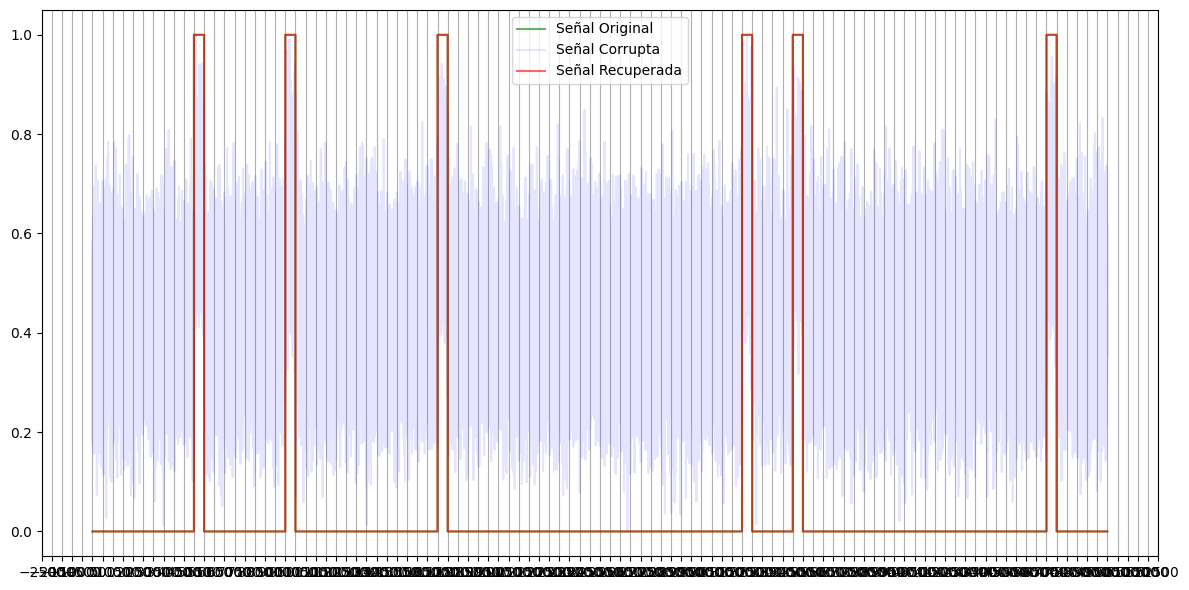

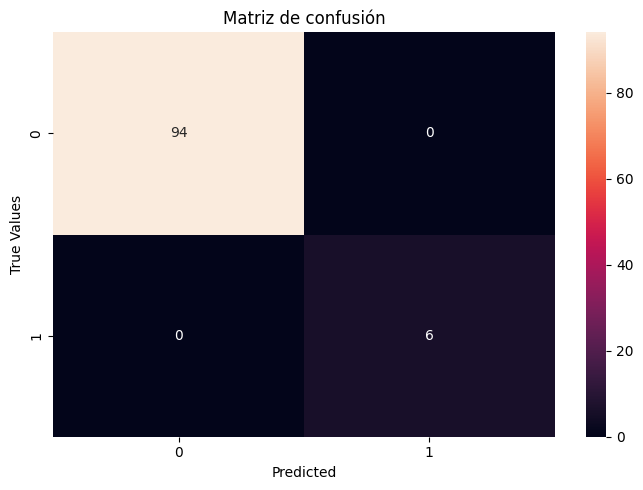

In [387]:
p_0 = 0.9
message_test_corrupt, message_test_orig, time = generate_symbols(p_0=p_0, Nsymbols=100, var_noise=0.5) 

message_predict = modelo.predict(message_test_corrupt)
message_predict = message_predict.flatten()
message_predict = np.where(message_predict >= 0.5, 1, 0)
message_predict = np.array([[x]*Nsamples for x in message_predict])
message_predict = message_predict.flatten()
 
plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time,message_test_orig, 'g', label='Señal Original', alpha=0.6)
plt.step(time,message_test_corrupt.flatten(), 'b', label='Señal Corrupta', alpha=0.1)
plt.step(time,message_predict, 'r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  # Solo cuadrícula vertical
plt.show()

matrix = confusion_matrix(message_test_orig, message_predict)/Nsamples
plt.figure(figsize=(7,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()


## 3) Ruidos con varianza difernete para cada simbolo: $N_1(x_1, \sigma_1) \neq N_2(x_2, \sigma_2) $

4/4 [==============================] - 0s 3ms/step


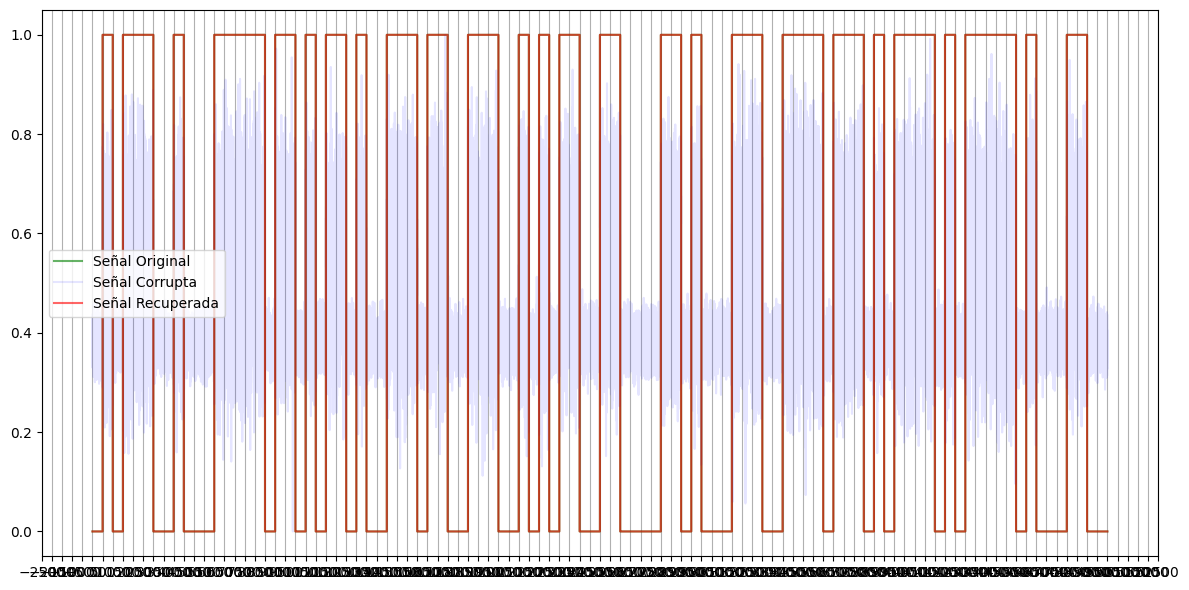

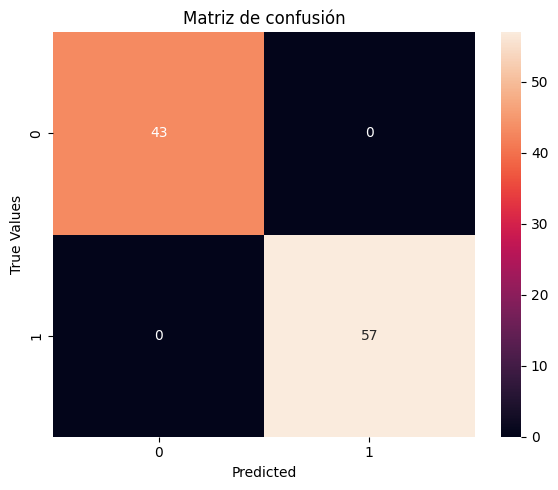

In [ ]:
Nsamples = 500
message_test_corrupt, message_test_orig, time = generate_symbols(Nsymbols=100, Nsamples=Nsamples, var_noise=(0.2, 0.8)) 
message_predict = predict_simbol(message_test_corrupt, modelo, 500)

plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time,message_test_orig, 'g', label='Señal Original', alpha=0.6)
plt.step(time,message_test_corrupt.flatten(), 'b', label='Señal Corrupta', alpha=0.1)
plt.step(time,message_predict, 'r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  #cuadrícula por símbolo
plt.show()

matrix = confusion_matrix(message_test_orig, message_predict)/Nsamples
plt.figure(figsize=(6,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()

## 4) Representación Diferencial: $N_1(0,\sigma_1)-N_2(0,\sigma_2)=0$  